In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import numpy as np
from nuance import Nuance
from tinygp import kernels, GaussianProcess

df = pd.read_csv("/Users/lgrcia/Downloads/data_toi540/P10.0_R0.97_1412.5708862326005.csv")
time, flux, error = df.values.T
t_0 = time[0]
time -= t_0

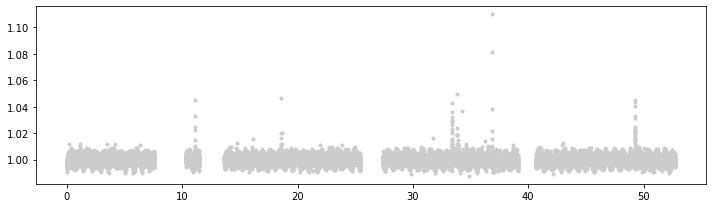

In [6]:
plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.tight_layout()

# Design matrix

In [7]:
X = time**np.arange(0, 3)[:, None]
X[1::] -= X[1::].mean(1)[:, None]
X[1::] /= X[1::].std(1)[:, None]

# GP

In [8]:
from tinygp import kernels, GaussianProcess
import yaml

params = yaml.full_load(open("../data/gp.yaml", "r"))

kernel = kernels.quasisep.SHO(
    omega=params["omega"], 
    quality=params["quality"], 
    sigma=params["sigma"]
) 
    
gp = GaussianProcess(kernel, time, diag=params["jitter"]**2, mean=1.)

# Sigclip

In [16]:
import jax

def mu(self, mask=None):
    if mask is None:
        mask = mask = np.ones_like(self.x).astype(bool)

    @jax.jit
    def _mu():
        gp = self.gp
        _, w, _ = self.eval_m(np.zeros_like(self.time))
        w = w[0:-1]
        cond_gp = gp.condition(self.flux - w@self.X, self.time).gp
        return cond_gp.loc + w@self.X

    return _mu()

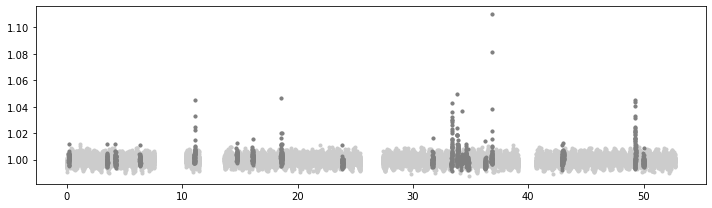

In [17]:
nu = Nuance(time, flux, kernel=kernel, error=error, X=X)

mask = np.ones_like(time).astype(bool)
mask_down = np.ones_like(time).astype(bool)
window = 30

plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")

for i in range(3):
    if i == 0:
        m = np.mean(flux)
    else:
        m = mu(nu, mask)
    #plt.plot(m)
    r = (flux - m)
    mask_up = np.array(np.minr < np.std(r[mask])*4)
    #mask_down = np.array(r > - np.std(r[mask])*1.5)

    # mask around flares
    ups = np.flatnonzero(~mask_up)
    if len(ups) > 0:
        mask_up[np.hstack([np.arange(max(u-window, 0), min(u+window, len(nu.time))) for u in ups])] = False
    mask = np.logical_and(mask_up, mask_down)

plt.figure(None, (10, 3))
plt.plot(time, flux, ".", c="0.8")
plt.plot(time[~mask], flux[~mask], ".", c="0.5")
plt.tight_layout()

In [11]:
m

DeviceArray([0.99720573, 0.99717845, 0.99714496, ..., 0.99896792,
             0.99894579, 0.99893467], dtype=float64)

In [67]:
import numpy as np
from scipy.signal import welch

def estimate_red_noise(signal, fs):
    f, Pxx_den = welch(signal, fs, nperseg=1024, scaling='density')
    Pxx_den = 10*np.log10(Pxx_den)
    Pxx_den = Pxx_den[f>0]
    f = f[f>0]
    slope, _ = np.polyfit(np.log10(f), Pxx_den, 1)
    return slope

# Linear search

In [76]:
from nuance import Nuance
from tinygp import kernels, GaussianProcess

nu = Nuance(time[mask], flux[mask], error[mask], kernel=kernel, X=X[:, mask])

t0s = time.copy()
Ds = np.linspace(0.01, 0.1, 10)
nu.linear_search(t0s, Ds)

100%|██████████████████████████████████████| 31570/31570 [00:58<00:00, 535.72it/s]


# Periodic search 1

In [77]:
periods = np.linspace(.8, 12., 15000)
search = nu.periodic_search(periods)

100%|██████████████████████████████████████| 15000/15000 [00:48<00:00, 311.41it/s]


In [78]:
def binn(x, y, n):
    N = int(len(x)/n)
    ns = np.histogram(x, N)[0]
    bx = np.histogram(x, N, weights=x)[0]/ns
    by = np.histogram(x, N, weights=y)[0]/ns
    return bx, by

(-0.0069111868181658195, 0.0069111868181658195)

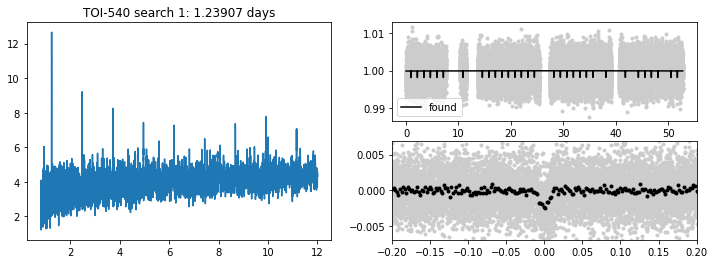

In [79]:
from nuance.utils import phase

def binn(x, y, n):
    N = int(len(x)/n)
    ns = np.histogram(x, N)[0]
    bx = np.histogram(x, N, weights=x)[0]/ns
    by = np.histogram(x, N, weights=y)[0]/ns
    return bx, by

plt.figure(None, (12, 4))
t0, D, P = search.best

plt.subplot(2, 2, (1, 3))
plt.plot(search.periods, search.Q_snr)
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu.time, nu.flux, ".", c="0.8")
plt.plot(nu.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu.models(t0, D, P)
phi = phase(nu.time, t0, P)
detrended = nu.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# Search 2

In [80]:
nu2 = nu.mask(t0, D, P)
search2 = nu2.periodic_search(periods)

100%|██████████████████████████████████████| 15000/15000 [00:45<00:00, 329.13it/s]


(-0.007690788736250041, 0.007690788736250041)

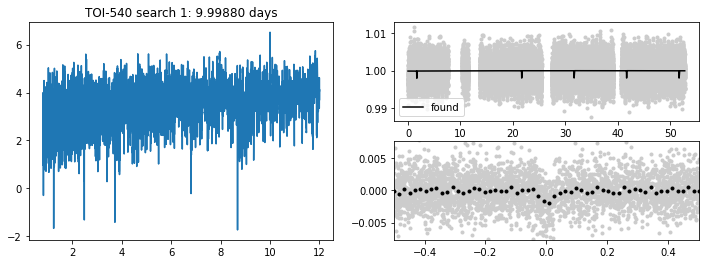

In [81]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search2.best

plt.subplot(2, 2, (1, 3))
plt.plot(search2.periods, search2.Q_snr)
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu2.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu2.time, nu2.flux, ".", c="0.8")
plt.plot(nu2.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu2.models(t0, D, P)
phi = phase(nu2.time, t0, P)
detrended = nu2.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# search 3

In [82]:
nu3 = nu2.mask(t0, D, P)
search3 = nu3.periodic_search(periods)

100%|██████████████████████████████████████| 15000/15000 [00:46<00:00, 323.53it/s]


(-0.0073678354582351795, 0.0073678354582351795)

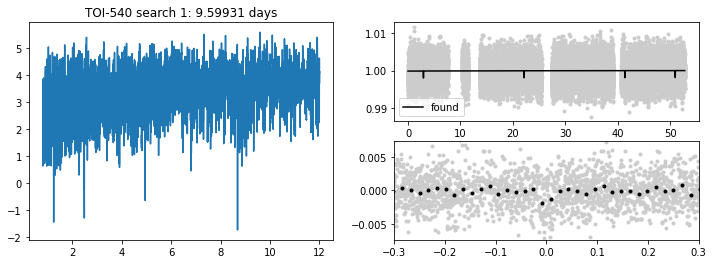

In [83]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search3.best

plt.subplot(2, 2, (1, 3))
plt.plot(search3.periods, search3.Q_snr)
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu3.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu3.time, nu3.flux, ".", c="0.8")
plt.plot(nu3.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu3.models(t0, D, P)
phi = phase(nu3.time, t0, P)
detrended = nu3.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

In [29]:
search3 = nu2.periodic_search(periods, fancy=False)

  0%|          | 0/2000 [00:00<?, ?it/s]

(-0.00541145215435176, 0.00541145215435176)

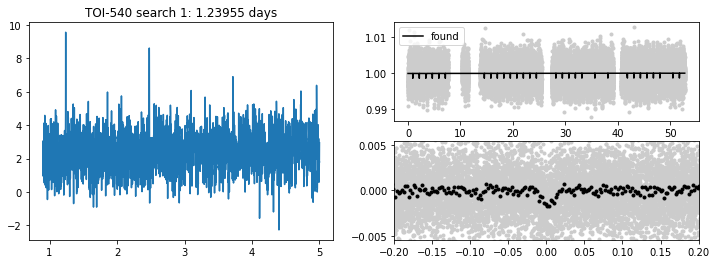

In [15]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search3.best

plt.subplot(2, 2, (1, 3))
plt.plot(search3.periods, search3.Q_snr)
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu2.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu2.time, nu2.flux, ".", c="0.8")
plt.plot(nu2.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu2.models(t0, D, P)
phi = phase(nu2.time, t0, P)
detrended = nu2.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4)

In [54]:
snra = []
snrb = []

from tqdm import tqdm

n = nu2
fold = n.search_data.fold_ll

for p in tqdm(periods):
    phase, a, b = fold(p)
    # a
    i, j = np.unravel_index(np.argmax(a), a.shape)
    Ti = phase[i] * p
    Dj = search.Ds[j]
    snra.append(float(n.snr(Ti, Dj, p)))
    # b
    i, j = np.unravel_index(np.argmax(b), b.shape)
    Ti = phase[i] * p
    Dj = search.Ds[j]
    snrb.append(float(n.snr(Ti, Dj, p)))

  2%|▉                                         | 118/5000 [00:02<01:29, 54.67it/s]


KeyboardInterrupt: 

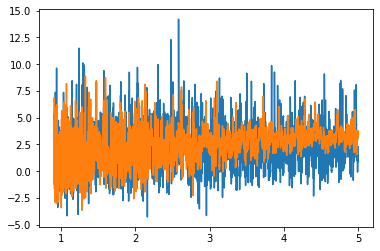

In [53]:
plt.plot(periods, snra)
plt.plot(periods, snrb)

In [27]:
def snr(x):
    i, j = np.unravel_index(np.argmax(x), x.shape)
    Ti = phase[i] * P
    Dj = search.Ds[j]
    return float(nu.snr(Ti, Dj, P))

In [81]:
from nuance import utils
from nuance.search_data import *
from nuance.utils import *

def Ps(lls, zs, vzs):
    vZ = 1/np.sum(1/vzs, 0)
    Z = vZ * np.sum(zs/vzs, 0)
    P1 = np.sum(lls, 0)
    P2 = 0.5*np.sum(np.log(vzs) - np.log(vzs + vZ) + (zs-Z)**2/(vzs+vZ), 0)
    return P1, P1-P2

def _folds(self):

    f_ll = interp2d(self.Ds, self.t0s, self.ll)
    f_z = interp2d(self.Ds, self.t0s, self.z)
    f_dz2 = interp2d(self.Ds, self.t0s, self.vz)

    def interpolate_all(pt0s):
        # computing the likelihood folds by interpolating in phase
        folds_ll = np.array([f_ll(self.Ds, t) for t in pt0s])
        folds_z = np.array([f_z(self.Ds, t) for t in pt0s])
        folds_vz = np.array([f_dz2(self.Ds, t) for t in pt0s])

        return folds_ll, folds_z, folds_vz

    def _folds(p):
        pt0s = utils.interp_split_times(self.t0s, p)
        return pt0s, interpolate_all(pt0s)

    return _folds

def fold_ll(self):
    folds = _folds(self)

    def _fold(p):
        pt0s, (lls, zs, vzs) = folds(p)
        P1, P2 = Ps(lls, zs, vzs)   

        return pt0s[0]/p, P1, P2

    return _fold

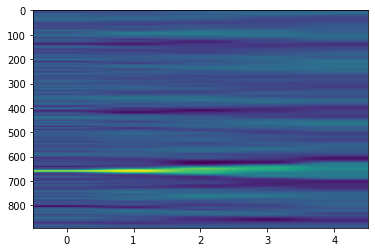

In [87]:
plt.imshow(fold_ll(nu.search_data)(1.2395)[2], aspect="auto")

In [48]:
from tqdm import tqdm

periods = np.linspace(0.05, 2, 2000)

fold_ll = fold_ll(nu.search_data)
n = len(periods)
snr = np.zeros(n)
m = np.zeros(n)
m1 = np.zeros(n)
m2 = np.zeros(n)

for p, P in enumerate(tqdm(periods)):
    phase, P1, P2 = fold_ll(P)
    m1[p] = np.max(P1) - np.mean(P1)
    m2[p]= np.max(P2) - np.mean(P2)
    #P1
    i, j = np.unravel_index(np.argmax(P2), P2.shape)
    Ti = phase[i] * P
    Dj = nu.search_data.Ds[j]
    snr[p] = float(nu.snr(Ti, Dj, P))

100%|█████████████████████████████████████████| 2000/2000 [00:43<00:00, 45.71it/s]


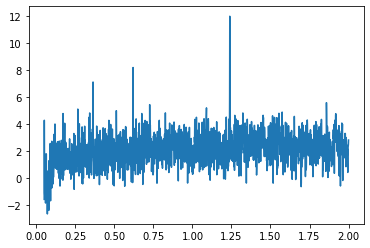

In [325]:
plt.plot(periods, snr)

In [292]:
zoom_search2 = nu2.periodic_search(np.arange(P-0.01, P+0.01, .00001))
print(zoom_search2.best[-1])

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

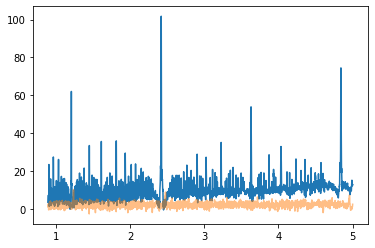

In [102]:
plt.plot(*search.periodogram())
plt.plot(*search2.periodogram(), alpha=0.5)

## Periodic search 3

In [42]:
nu3 = nu2.mask(t0, D, P)
search3 = nu3.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

(-0.004073407053483498, 0.004073407053483498)

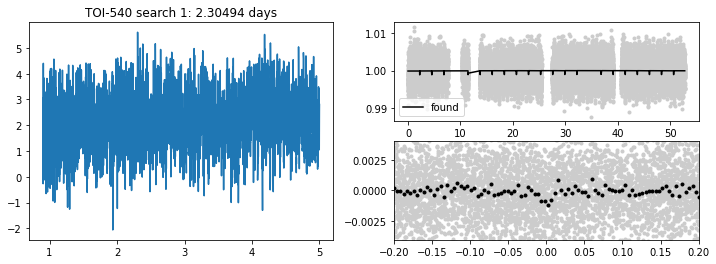

In [43]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search3.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search3.periodogram())
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu3.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu3.time, nu3.flux, ".", c="0.8")
plt.plot(nu3.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu3.models(t0, D, P)
phi = phase(nu3.time, t0, P)
detrended = nu3.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

In [44]:
nu3.snr(t0, D, P)

DeviceArray(5.60581265, dtype=float64)

## Periodic search 4

In [122]:
nu4 = mask(nu3, t0, D, P)
search4 = nu4.periodic_search(periods)

  0%|          | 0/5000 [00:00<?, ?it/s]

(-0.008869364626318684, 0.008869364626318684)

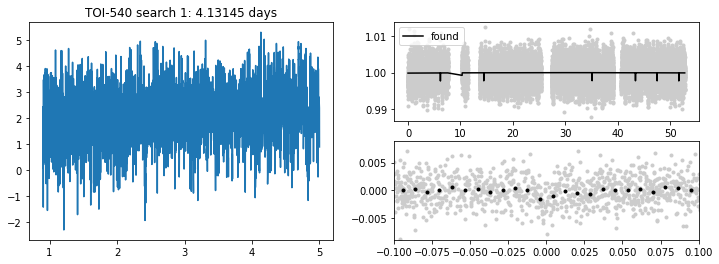

In [127]:
from nuance.utils import phase

plt.figure(None, (12, 4))
t0, D, P = search4.best

plt.subplot(2, 2, (1, 3))
plt.plot(*search4.periodogram())
plt.title(f"TOI-540 search 1: {P:.5f} days")

mean, astro, noise = nu4.models(t0, D, P)

plt.subplot(2, 2, 2)
plt.plot(nu4.time, nu4.flux, ".", c="0.8")
plt.plot(nu4.time, astro + mean, c="k", label="found")
ylim = plt.ylim()
_ = plt.legend()

plt.subplot(2, 2, 4)
mean, astro, noise = nu4.models(t0, D, P)
phi = phase(nu4.time, t0, P)
detrended = nu4.flux - noise - mean
plt.plot(phi, detrended, ".", c=".8")
plt.plot(*binn(phi, detrended, 50), ".", c="k")
plt.xlim(*(np.array([-1, 1])*10*D))
plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

In [128]:
nu4.snr(t0, D, P)

DeviceArray(5.31044354, dtype=float64)

In [15]:
def plot_phase_folded(self, t0, D, P, detrended=True, bins=0.2):
    mean, astro, noise = self.models(t0, D, P)
    if detrended:
        detrended = self.flux - noise - mean
    else:
        detrended = self.flux - np.median(flux)
    phi = phase(self.time, t0, P)
    plt.plot(phi, detrended, ".", c=".8")
    dt = np.median(np.diff(self.time))
    plt.plot(*binn(phi, detrended, bins/dt), ".", c="k")
    plt.xlim(*(np.array([-1, 1])*10*D))
    plt.ylim(*(np.array([-1, 1])*float(np.abs(astro.min()))*4))

# Explore results

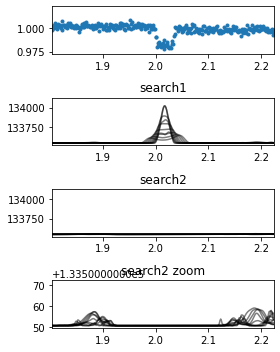

In [56]:
t0, D, P = search.best
#t0 += 4*P
xlim = (t0 + np.array([-1, 1])*7*D)

plt.figure(figsize=(4, 5))
plt.subplot(411)
plt.plot(nu.x, nu.y, ".")
plt.xlim(*xlim)

plt.subplot(412)
plt.plot(search.t0s, search.ll, c="k", alpha=0.5)
plt.xlim(*xlim)
ylim = plt.ylim()
plt.title("search1")

plt.subplot(413)
plt.title("search2")
plt.plot(search2.t0s, search2.ll, c="k", alpha=0.5)
plt.xlim(*xlim)
plt.ylim(ylim)

plt.subplot(414)
plt.title("search2 zoom")
plt.plot(search2.t0s, search2.ll, c="k", alpha=0.5)
plt.xlim(*xlim)

plt.tight_layout()

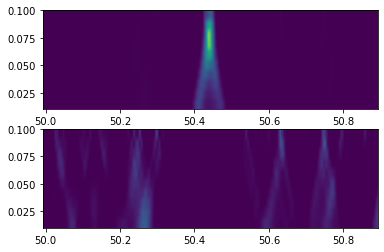

In [57]:
from scipy.interpolate import interp2d

t0, D, P = search.best
t0 += 20*P
xlim = (t0 + np.array([-1, 1])*15*D)
x = np.arange(nu.x.min(), nu.x.max(), 0.001)

plt.subplot(211)
fll = interp2d(search.Ds, search.t0s, search.ll)
plt.imshow(fll(search.Ds, x).T, aspect='auto', extent=(x.min(), x.max(), search.Ds.min(), search.Ds.max()), vmin=search.ll0)
_ = plt.xlim(*xlim)

plt.subplot(212)
fll = interp2d(search.Ds, search.t0s, search2.ll)
plt.imshow(fll(search.Ds, x).T, aspect='auto', extent=(x.min(), x.max(), search.Ds.min(), search.Ds.max()), vmin=search.ll0)
_ = plt.xlim(*xlim)

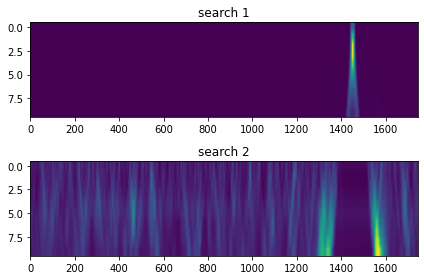

In [58]:
t0, D, P = search.best
plt.subplot(211)
plt.imshow(search.fold(P)[1].T, aspect='auto')
plt.title("search 1")
plt.subplot(212)
plt.imshow(search2.fold(P)[1].T, aspect='auto')
plt.title("search 2")
plt.tight_layout()

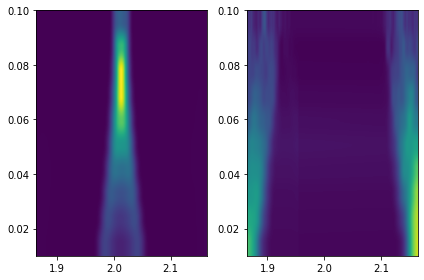

In [59]:
t0, D, P = search.best
xlim = (t0 + np.array([-1, 1])*5*D)

plt.subplot(121)
a, b, _ = search.fold(P)
plt.imshow(b.T, aspect='auto', extent=(a.min()*P, a.max()*P, search.Ds.min(), search.Ds.max()))
_ = plt.xlim(*xlim)

plt.subplot(122)
a, b, _ = search2.fold(P)
plt.imshow(b.T, aspect='auto', extent=(a.min()*P, a.max()*P, search.Ds.min(), search.Ds.max()))
_ = plt.xlim(*xlim)
plt.tight_layout()

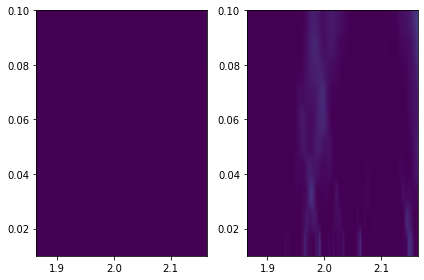

In [60]:
plt.subplot(121)
search.show_ll()
_ = plt.xlim(*xlim)

plt.subplot(122)
search2.show_ll()
_ = plt.xlim(*xlim)

plt.tight_layout()